In [1]:
#Environment setup
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
#libraries loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM








2022-11-19 22:01:16.413766: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_xmr = pd.read_csv("XMR-USD.csv")# Data loading


data_xmr.head()#data viewing

,Date,Open,High,Low,Close,Adj Close,Volume,key
0,2017-11-09,112.531998,123.404999,112.219002,120.779999,120.779999,86864600,xmr_usd
1,2017-11-10,121.344002,121.665001,101.757004,105.585999,105.585999,84614000,xmr_usd
2,2017-11-11,105.750000,127.106003,103.877998,119.615997,119.615997,107708000,xmr_usd
3,2017-11-12,119.597000,133.675003,110.617996,123.856003,123.856003,144948000,xmr_usd
4,2017-11-13,128.960007,136.528000,120.921997,123.402000,123.402000,116200000,xmr_usd


In [3]:
#counting how many times a similar value occurs
data_xmr['Close'].value_counts() 
data_xmr['Open'].value_counts()

381.303009    2
112.531998    1
224.992722    1
206.349228    1
217.350159    1
             ..
88.441093     1
87.759079     1
100.008926    1
101.674782    1
140.747223    1
Name: Open, Length: 1808, dtype: int64

In [4]:
df = data_xmr.loc[(data_xmr['key'] == 'xmr_usd')]
df.head(1810)

,Date,Open,High,Low,Close,Adj Close,Volume,key
0,2017-11-09,112.531998,123.404999,112.219002,120.779999,120.779999,86864600,xmr_usd
1,2017-11-10,121.344002,121.665001,101.757004,105.585999,105.585999,84614000,xmr_usd
2,2017-11-11,105.750000,127.106003,103.877998,119.615997,119.615997,107708000,xmr_usd
3,2017-11-12,119.597000,133.675003,110.617996,123.856003,123.856003,144948000,xmr_usd
4,2017-11-13,128.960007,136.528000,120.921997,123.402000,123.402000,116200000,xmr_usd
...,...,...,...,...,...,...,...,...
1804,2022-10-18,143.624588,148.039398,142.697784,146.093826,146.093826,118028731,xmr_usd
1805,2022-10-19,146.099319,148.462082,144.796875,145.044846,145.044846,81641779,xmr_usd
1806,2022-10-20,145.041626,148.424316,140.163910,141.207642,141.207642,86726962,xmr_usd
1807,2022-10-21,141.195435,143.249649,137.309967,140.729477,140.729477,80536580,xmr_usd


In [5]:
#date time collection
df = df.reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.loc[df['Date'] > pd.to_datetime('2017-06-28')]

In [6]:
df = df[['Date','Open','Close','High','Low','Volume']]

In [7]:
df.head()

,Date,Open,Close,High,Low,Volume
0,2017-11-09,112.531998,120.779999,123.404999,112.219002,86864600
1,2017-11-10,121.344002,105.585999,121.665001,101.757004,84614000
2,2017-11-11,105.750000,119.615997,127.106003,103.877998,107708000
3,2017-11-12,119.597000,123.856003,133.675003,110.617996,144948000
4,2017-11-13,128.960007,123.402000,136.528000,120.921997,116200000


In [8]:
df = df[['Close']]

In [9]:
dataset = df.values
dataset = dataset.astype('float32')

In [10]:
dataset

array([[120.78   ],
       [105.586  ],
       [119.616  ],
       ...,
       [141.20764],
       [140.72948],
       [142.07094]], dtype=float32)

In [11]:
#Rescaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scale = scaler.fit_transform(dataset)

In [12]:
dataset_scale

array([[0.19479558],
       [0.16107407],
       [0.1922122 ],
       ...,
       [0.24013257],
       [0.23907134],
       [0.24204856]], dtype=float32)

In [13]:
#training set size
train_size = int(len(dataset_scale) * 0.709)
test_size = len(dataset_scale) - train_size
train, test = dataset_scale[0:train_size, :], dataset_scale[train_size:len(dataset), :]
print(len(train), len(test))

1282 527


In [14]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [15]:
look_back = 20
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)


In [16]:
trainX


array([[0.19479558, 0.16107407, 0.1922122 , ..., 0.28932846, 0.31156236,
        0.3777403 ],
       [0.16107407, 0.1922122 , 0.20162243, ..., 0.31156236, 0.3777403 ,
        0.29992828],
       [0.1922122 , 0.20162243, 0.20061484, ..., 0.3777403 , 0.29992828,
        0.32653442],
       ...,
       [0.81717575, 0.76962095, 0.6991752 , ..., 0.9413223 , 0.9819989 ,
        1.        ],
       [0.76962095, 0.6991752 , 0.7143635 , ..., 0.9819989 , 1.        ,
        0.9069047 ],
       [0.6991752 , 0.7143635 , 0.7712475 , ..., 1.        , 0.9069047 ,
        0.9333017 ]], dtype=float32)

In [17]:
trainY

array([0.29992828, 0.32653442, 0.3505039 , ..., 0.9069047 , 0.9333017 ,
       0.7975897 ], dtype=float32)

In [18]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [19]:
#Model set-up
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=105, batch_size=280, verbose=2)

Epoch 1/105
5/5 - 2s - loss: 0.1035 - 2s/epoch - 393ms/step
Epoch 2/105
5/5 - 0s - loss: 0.0923 - 9ms/epoch - 2ms/step
Epoch 3/105
5/5 - 0s - loss: 0.0814 - 10ms/epoch - 2ms/step
Epoch 4/105
5/5 - 0s - loss: 0.0712 - 9ms/epoch - 2ms/step
Epoch 5/105
5/5 - 0s - loss: 0.0617 - 9ms/epoch - 2ms/step
Epoch 6/105
5/5 - 0s - loss: 0.0526 - 7ms/epoch - 1ms/step
Epoch 7/105
5/5 - 0s - loss: 0.0445 - 8ms/epoch - 2ms/step
Epoch 8/105
5/5 - 0s - loss: 0.0371 - 9ms/epoch - 2ms/step
Epoch 9/105
5/5 - 0s - loss: 0.0307 - 8ms/epoch - 2ms/step
Epoch 10/105
5/5 - 0s - loss: 0.0249 - 9ms/epoch - 2ms/step
Epoch 11/105
5/5 - 0s - loss: 0.0200 - 7ms/epoch - 1ms/step
Epoch 12/105
5/5 - 0s - loss: 0.0162 - 9ms/epoch - 2ms/step
Epoch 13/105
5/5 - 0s - loss: 0.0131 - 8ms/epoch - 2ms/step
Epoch 14/105
5/5 - 0s - loss: 0.0109 - 8ms/epoch - 2ms/step
Epoch 15/105
5/5 - 0s - loss: 0.0092 - 8ms/epoch - 2ms/step
Epoch 16/105
5/5 - 0s - loss: 0.0081 - 8ms/epoch - 2ms/step
Epoch 17/105
5/5 - 0s - loss: 0.0072 - 8ms/epoc

In [20]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

16/16 [==============================] - 0s 799us/step


In [118]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [119]:

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 18.36 RMSE
Test Score: 19.18 RMSE


In [120]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
 

In [121]:
 # shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict
 

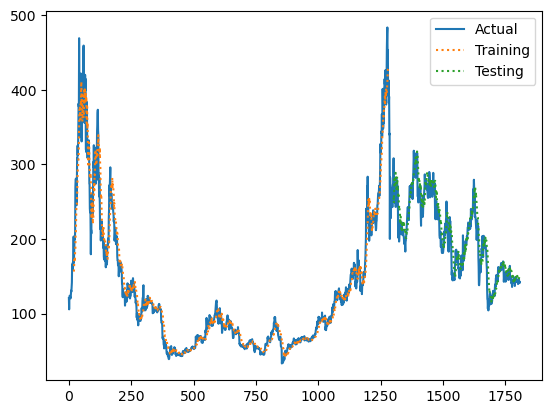

In [122]:
plt.plot(df['Close'], label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='Training',linestyle = 'dotted')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='Testing',linestyle = 'dotted')
plt.legend(loc='best')
plt.show()

In [130]:
from sklearn.metrics import mean_squared_error

mean_squared_error(testY[0].reshape(-1),testPredict[:, 0])



368.05114324967303

In [144]:
from sklearn.metrics import accuracy_score
#accuracy_score(testY, testPredict)
print(testY)

[[308.18878105 287.46372412 264.30828302 272.59470168 248.9333692
  254.8754243  274.33165719 255.35590966 242.98159213 242.96053682
  261.19462187 269.93550217 279.49571328 262.21862423 277.10905111
  264.84452197 270.52072695 264.60085512 203.36182643 201.53153198
  212.46378916 225.06806342 196.50369085 202.77748791 211.19907413
  212.44874965 217.1449831  222.26943963 206.56387153 211.34514533
  214.75277511 219.84141882 214.46499685 222.13713226 214.85055876
  205.44129326 212.74700186 209.55689436 211.52144326 206.81245308
  203.54851772 203.24548511 196.19939599 193.12627436 197.61168617
  199.52015919 188.79560833 183.09679038 196.41044591 197.63129124
  203.56358409 208.66444739 213.48745582 218.51184592 226.09950496
  234.79631415 241.22916741 242.79778788 240.17027876 236.231459
  233.06784521 225.19591264 244.96839144 252.86155388 263.03653165
  270.97927074 256.85373703 270.18650078 266.17224179 268.56924362
  257.09708161 273.06651247 271.28559325 272.23694943 267.8723773

In [64]:
    from keras.models import load_model
    model.save('xmr.h5') 
    model.save_weights('xmr_weights.h5')  # to store